In [1]:
#! /usr/bin/env python
"""
Leave-one-out cross validation of debris thickness extrapolation methods
"""
import sys
import os
import re
import subprocess
from datetime import datetime, timedelta
import time
import pickle
from collections import OrderedDict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy import ndimage
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.stats import median_absolute_deviation
import xarray as xr
from osgeo import gdal, ogr, osr

from pygeotools.lib import malib, warplib, geolib, iolib, timelib


import debrisglobal.globaldebris_input as debris_prms
from debrisglobal.glacfeat import GlacFeat, create_glacfeat
from meltcurves import melt_fromdebris_func
from meltcurves import debris_frommelt_func
from spc_split_lists import split_list


debug=False

In [2]:
#Function to generate a 3-panel plot for input arrays
def plot_array(dem, clim=None, titles=None, cmap='inferno', label=None, overlay=None, fn=None, close_fig=True):
    fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,5))
    alpha = 1.0
    #Gray background
    ax.set_facecolor('0.5')
    #Force aspect ratio to match images
    ax.set(aspect='equal')
    #Turn off axes labels/ticks
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if titles is not None:
        ax.set_title(titles[0])
    #Plot background shaded relief map
    if overlay is not None:
        alpha = 0.7
        ax.imshow(overlay, cmap='gray', clim=(1,255))
    #Plot each array
    im_list = [ax.imshow(dem, clim=clim, cmap=cmap, alpha=alpha)]
    fig.tight_layout()
    fig.colorbar(im_list[0], label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)
    if close_fig:
        plt.close(fig)
        
        
def maskedarray_gt(data, value):
    """ Greater than operation on masked array to avoid warning errors """
    data = np.nan_to_num(data,0)
    data[data > value] = value
    return data


def maskedarray_lt(data, value):
    """ Less than operation on masked array to avoid warning errors """
    data = np.nan_to_num(data,0)
    data[data < value] = value
    return data


def ts_fromdebris_func(h, a, b, c):
    """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
        Hill Equation"""
    return a * h**c / (b**c + h**c)


def debris_fromts_func(ts, a, b, c, hd_max=debris_prms.hd_max):
    """ estimate debris thickness from surface temperature (ts is surface temperature, a and k are coefficients) 
        Hill Equation"""
    # If temperature exceeds maximum of function cause NaN value
    max_value = ts_fromdebris_func(50, a, b, c)
    if ts.size == 1:
        if ts > max_value:
            ts = max_value
        if ts < 0:
            ts = 0
    else:
        ts[ts > a] = max_value
        ts[ts < 0] = 0
    # Debris thickness
    hd = (ts * b**c / (a - ts))**(1/c)
    return hd
        
    
def debris_fromts_maskedarray(ts_raw, a, b, c):
    """ Apply debris_fromts_func to masked array
        includes a mask of maximum values, since Michaelis-Mentin Equation has natural maximum 
    Parameters
    ----------
    ts_raw : np.ma.array
        masked array of the unmodified surface temperature
    Returns
    -------
    hd : np.ma.array 
        masked array of the debris thickness (m)
    """
    hd = debris_fromts_func(ts_raw.data, a, b, c)
    return hd

In [3]:
# ===== DETERMINE ALL GLACIERS WITH AND WITHOUT OBSERVATIONS =====
hdopt_prms_fp = debris_prms.output_fp + 'hd_opt_prms/' + debris_prms.roi + '/'

# Glaciers optimized
glac_tsopt_fns = []
rgiid_list_tsopt = []
for roi_extrap in debris_prms.roi_dict_extrap[debris_prms.roi]:
    hdopt_prms_fp = debris_prms.output_fp + 'hd_opt_prms/' + roi_extrap + '/'
    for i in os.listdir(hdopt_prms_fp):
        if i.endswith('_hdopt_prms.csv'):
            region = int(i.split('.')[0])
            if region in debris_prms.roi_rgidict[roi_extrap]:    
                rgiid_list_tsopt.append(i.split('_')[0])            
                glac_tsopt_fns.append(i)
    glac_tsopt_fns = sorted(glac_tsopt_fns)
    rgiid_list_tsopt = sorted(rgiid_list_tsopt)
    

main_glac_rgi_tsopt = debris_prms.selectglaciersrgitable(rgiid_list_tsopt)

# All debris-covered glaciers
dc_shp = gpd.read_file(debris_prms.debriscover_fp + debris_prms.debriscover_fn_dict[debris_prms.roi])
dc_rgiid = sorted([x.split('-')[1] for x in dc_shp.RGIId])
main_glac_rgi_all = debris_prms.selectglaciersrgitable(glac_no=dc_rgiid)

# Merge with debris cover stats
dc_shp = gpd.read_file(debris_prms.debriscover_fp + debris_prms.debriscover_fn_dict[debris_prms.roi])
dc_shp = dc_shp.sort_values(by=['RGIId'])
dc_shp.reset_index(inplace=True, drop=True)

# Add debris stats to area
dc_areaperc_dict = dict(zip(dc_shp.RGIId.values,dc_shp['DC_Area__1'].values))
dc_area_dict = dict(zip(dc_shp.RGIId.values,dc_shp['DC_Area_v2'].values))

main_glac_rgi_tsopt['DC_Area_%'] = main_glac_rgi_tsopt.RGIId.map(dc_areaperc_dict).fillna(0)
main_glac_rgi_tsopt['DC_Area_v2'] = main_glac_rgi_tsopt['Area'] * main_glac_rgi_tsopt['DC_Area_%'] / 100

136 glaciers in region 2 are included in this model run: ['00737', '00914', '01104', '01152', '01158', '01161', '01290', '01291', '01297', '01339', '01397', '01441', '01665', '01685', '01727', '01811', '01812', '01922', '01923', '02107', '02348', '02360', '02386', '02432', '02526', '02533', '02550', '02551', '02616', '02686', '02745', '02747', '02752', '02784', '02857', '02894', '02897', '02947', '02948', '02966', '03099', '03102', '03157', '03581', '03597', '03664', '03769', '03922', '03943', '03963'] and more
This study is focusing on 136 glaciers in region [2]
3313 glaciers in region 2 are included in this model run: ['00006', '00016', '00018', '00020', '00039', '00079', '00097', '00098', '00118', '00126', '00134', '00147', '00157', '00173', '00174', '00180', '00208', '00212', '00226', '00227', '00242', '00252', '00255', '00256', '00259', '00280', '00288', '00289', '00291', '00296', '00305', '00317', '00330', '00336', '00343', '00346', '00347', '00354', '00366', '00377', '00378', '0

In [4]:
print('\n', debris_prms.roi + ': calibration includes', main_glac_rgi_tsopt.shape[0], 'glaciers covering',
      str(np.round(main_glac_rgi_tsopt['DC_Area_v2'].sum(),1)), 'km2')     


 02: calibration includes 136 glaciers covering 94.2 km2


In [5]:
main_glac_rgi_missing = main_glac_rgi_tsopt.copy()

# print('\nHACK TO EXTRAPOLATE TO CALIBRATED GLACIERS FOR COMPARISON\n')
# rgiids_missing = ['15.03733']
# main_glac_rgi_missing = debris_prms.selectglaciersrgitable(rgiids_missing)

In [6]:
extrap_uncalibrated_glaciers = True
overwrite_hd = True

# NEW FILE PATHS FOR CROSS VALIDATION
hd_fp_crossval = debris_prms.hd_fp + '../../hd_tifs_extrap_crossval/' + debris_prms.roi + '/'
if not os.path.exists(hd_fp_crossval):
    os.makedirs(hd_fp_crossval)

fig_extrap = debris_prms.output_fig_fp + 'cross_val/' + debris_prms.roi + '/'
if not os.path.exists(fig_extrap):
    os.makedirs(fig_extrap)

FileExistsError: [Errno 17] File exists: '/Users/drounce/Documents/DebrisGlaciers_WG/Melt_Intercomparison/debris_global/../output/ts_tif/02_ts_data/../hd_tifs/02/../../hd_tifs_extrap_crossval/02/'

In [7]:
if extrap_uncalibrated_glaciers and overwrite_hd:
    
    # ===== NEAREST GLACIERS WITH DATA =====
    n_glac_nearest = 1000 + 1  # add one for the cross validation so it's not using itself
    if n_glac_nearest > main_glac_rgi_tsopt.shape[0]:
        n_glac_nearest = main_glac_rgi_tsopt.shape[0]

    nearest_dict = {}
    for nglac, glac_idx in enumerate(main_glac_rgi_missing.index.values):
#     for nglac, glac_idx in enumerate([main_glac_rgi_missing.index.values[0]]):
        glac_str = main_glac_rgi_missing.loc[glac_idx, 'rgino_str']
        if glac_idx%500 == 0:
            print(glac_idx, glac_str)
        latlon_dist = (((main_glac_rgi_tsopt['CenLat'].values - main_glac_rgi_missing['CenLat'].values[glac_idx])**2 + 
                        (main_glac_rgi_tsopt['CenLon'].values - main_glac_rgi_missing['CenLon'].values[glac_idx])**2)**0.5)

        latlon_nearidx_list = np.argsort(latlon_dist)[0:n_glac_nearest]
        rgiid_nearest_list = list(main_glac_rgi_tsopt.loc[latlon_nearidx_list,'rgino_str'].values)

        nearest_dict[glac_str] = rgiid_nearest_list[1:]

    # Ts filenames
    ts_fns_df = pd.read_csv(debris_prms.ts_fp + debris_prms.ts_fns_fn)
    
    # Record differences on pixel level for histograms
    hd_latlon_dist_med_all = None
    hd_cal_all, hd_dif_all, mf_cal_all, mf_dif_all = None, None, None, None
    hd_glac_med_all, hd_glac_med_dif_all, mf_glac_med_all, mf_glac_med_dif_all = None, None, None, None
    for nglac, glac_idx in enumerate(main_glac_rgi_missing.index.values):
#     for nglac, glac_idx in enumerate(main_glac_rgi_missing.index.values[0:5]):
        glac_str = main_glac_rgi_missing.loc[glac_idx, 'rgino_str']
        rgiid = main_glac_rgi_missing.loc[glac_idx,'RGIId']
        region = glac_str.split('.')[0]

        if int(region) < 10:
            glac_str_noleadzero = str(int(glac_str.split('.')[0])) + '.' + glac_str.split('.')[1]
        else:
            glac_str_noleadzero = glac_str

        # Ts filename
        ts_fn_idx = np.where(ts_fns_df['RGIId'].values == rgiid)[0][0]
        ts_fn = ts_fns_df.loc[ts_fn_idx,'ts_fullfn']
        
        # Hd filename
        hd_fn = debris_prms.hd_fn_sample.replace('XXXX', glac_str_noleadzero).replace('.tif','_extrap.tif')

        # Ice thickness filenames
        thick_dir = debris_prms.oggm_fp + 'thickness/RGI60-' + str(region.zfill(2)) + '/'
        thick_fn = 'RGI60-' + str(region.zfill(2)) + '.' + rgiid.split('.')[1] + '_thickness.tif'

        # Record values from nearest for the melt factors after debris thickness is extrapolated
        melt_2cm_nearest = None
        melt_cleanice_nearest = None
        func_coeff_nearest = None
        
        if os.path.exists(thick_dir + thick_fn) and ts_fn not in ['0.0']:
            
            print(glac_idx, glac_str)
            
            # Create glacier feature
            gf = create_glacfeat(thick_dir, thick_fn)
        
            # Debris shape layer processing
            dc_shp_proj_fn = (debris_prms.glac_shp_proj_fp + glac_str + '_dc_crs' + 
                              str(gf.aea_srs.GetAttrValue("AUTHORITY", 1)) + '.shp')
            if not os.path.exists(dc_shp_proj_fn):
                dc_shp_init = gpd.read_file(debris_prms.debriscover_fp + 
                                            debris_prms.debriscover_fn_dict[debris_prms.roi])
                dc_shp_single = dc_shp_init[dc_shp_init['RGIId'] == rgiid]
                dc_shp_single = dc_shp_single.reset_index()
                dc_shp_proj = dc_shp_single.to_crs({'init': 'epsg:' + 
                                                    str(gf.aea_srs.GetAttrValue("AUTHORITY", 1))})
                dc_shp_proj.to_file(dc_shp_proj_fn)
            dc_shp_ds = ogr.Open(dc_shp_proj_fn, 0)
            dc_shp_lyr = dc_shp_ds.GetLayer()

            # Add layers
            gf.add_layers(dc_shp_lyr, gf_add_ts=True, ts_fn=ts_fn, gf_add_slope_aspect=False)

            # ===== PLOTS =====
#             if debug:
#                 # DEM
#                 var_full2plot = gf.z1.copy()
#                 clim = malib.calcperc(var_full2plot, (2,98))
#                 plot_array(var_full2plot, clim, [glac_str + ' DEM'], 'inferno', 'elev (masl)', close_fig=False)
#                 # Surface temperature
#                 var_full2plot = gf.ts.copy()
#                 clim = malib.calcperc(var_full2plot, (2,98))
#                 plot_array(var_full2plot, clim, [glac_str + ' Ts'], 'inferno', 'ts (degC)', close_fig=False)
#                 # Surface temperature (debris-covered)
#                 var_full2plot = gf.ts.copy()
#                 var_full2plot.mask = gf.dc_mask
#                 clim = malib.calcperc(var_full2plot, (2,98))
#                 plot_array(var_full2plot, clim, [glac_str + ' Ts'], 'inferno', 'ts (degC)', close_fig=False)
            

            # ===== SURFACE TEMPERATURE FOR THINNEST DEBRIS (connected to terminus) =====
            outbins_df, z_bin_edges = gf.hist_plot(bin_width=debris_prms.mb_bin_size)   
            bin_idx_dc = np.where(outbins_df['dc_bin_count_valid'] > 0)[0]
            bin_idx_dif = list(bin_idx_dc[1:] - bin_idx_dc[:-1])
            if not(np.sum(bin_idx_dif) == len(bin_idx_dc)-1):
                idx_jumpinbins = bin_idx_dif.index(next(filter(lambda x: x>1, bin_idx_dif)))
                bin_idx_dc = bin_idx_dc[0:idx_jumpinbins+1]
            
            ts_min = np.nanmin(outbins_df.loc[bin_idx_dc,'dc_ts_med'].values)
            ts_max = np.nanmax(outbins_df.loc[bin_idx_dc,'dc_ts_med'].values)
            
            if debug:
                print('ts_min:', np.round(ts_min,1), ' ts_max:', np.round(ts_max,1))
            
            if np.isnan(ts_min) and np.isnan(ts_max):
                troubleshoot_fp = (debris_prms.output_fp + 'errors/no_Ts_data-extrap/' + debris_prms.roi + '/')
                if not os.path.exists(troubleshoot_fp):
                    os.makedirs(troubleshoot_fp)
                txt_fn_extrapfail = glac_str + "-noTs-extrap.txt"
                with open(troubleshoot_fp + txt_fn_extrapfail, "w") as text_file:
                    text_file.write(glac_str + ' no surface temperature data but made it past preprocessing to extrap')

            else:
                # ===== ESTIMATE DEBRIS THICKNESS FOR EACH GLACIER INDIVIDUALLY =====
                # Load parameters from nearest neighbor
                rgiid_nearest_list = nearest_dict[main_glac_rgi_missing.loc[glac_idx, 'rgino_str']]

                n_nearest = 0
                n_success = 0
                min_n_nearest = 10
                hd_ts_list = []
                hd_latlon_dist_list = []
                mf_list = []
                while n_nearest < n_glac_nearest - 1 and n_success < min_n_nearest:
                    rgi_str_nearest = rgiid_nearest_list[n_nearest]
                    
                    # distance of nearest glacier
                    nearest_idx = np.where(rgi_str_nearest == main_glac_rgi_tsopt.rgino_str)[0][0]
                    nearest_latlon_dist = (((main_glac_rgi_tsopt.loc[nearest_idx,'CenLat'] - 
                                             main_glac_rgi_missing.loc[glac_idx,'CenLat'])**2 + 
                                            (main_glac_rgi_tsopt.loc[nearest_idx,'CenLon'] - 
                                             main_glac_rgi_missing.loc[glac_idx,'CenLon'])**2)**0.5)
                    
                    if rgi_str_nearest.startswith('0'):
                        rgi_str_nearest = rgi_str_nearest[1:]
                    if debug:
                        print(n_nearest, 'rgi nearest:', rgi_str_nearest)

                    # Load parameters
                    df_opt_fn = rgi_str_nearest + '_hdopt_prms.csv'
                    roi_nearest = str(int(rgi_str_nearest.split('.')[0])).zfill(2)
                    if roi_nearest in ['13','14','15']:
                        roi_nearest = 'HMA'
                    hdopt_prms_fp = debris_prms.output_fp + 'hd_opt_prms/' + roi_nearest + '/'
                    df_opt = pd.read_csv(hdopt_prms_fp + df_opt_fn)
                    melt_2cm = df_opt.loc[0,'melt_mwea_2cm']
                    melt_cleanice = df_opt.loc[0,'melt_mwea_clean']
                    func_coeff = [df_opt.loc[0,'b0'], df_opt.loc[0,'k']]
                    func_coeff_ts = [df_opt.loc[0,'a'], df_opt.loc[0,'b'], df_opt.loc[0,'c']]
                    
                    if melt_2cm_nearest is None:
                        melt_2cm_nearest = melt_2cm.copy()
                        melt_cleanice_nearest = melt_cleanice.copy()
                        func_coeff_nearest = func_coeff.copy()

                    # Estimate debris thickness of thinnest bin
                    hd_thin = debris_fromts_func(ts_min, func_coeff_ts[0], func_coeff_ts[1], func_coeff_ts[2])
                    hd_thick = debris_fromts_func(ts_max, func_coeff_ts[0], func_coeff_ts[1], func_coeff_ts[2])
                    
                    if debug:
                        print('     thin:', np.round(ts_min,1), np.round(hd_thin,3), 'm', 
                              '    thick:', np.round(ts_max,1), np.round(hd_thick,3), 'm')

    #                 print(func_coeff_ts[0], func_coeff_ts[1], func_coeff_ts[2], ts_min, hd_thin)

                    # Minimum and maximum debris thickness are reasonable
                    if hd_thin > 0 and hd_thin < 0.2 and hd_thick < debris_prms.hd_max:

                        if debug:
                            print('  ', n_nearest, 'hd thin:', np.round(hd_thin,2), 'hd thick:', np.round(hd_thick,2))

                        hd_array = debris_fromts_maskedarray(gf.ts, func_coeff_ts[0], func_coeff_ts[1], func_coeff_ts[2])
                        hd_array[hd_array>debris_prms.hd_max] = debris_prms.hd_max
                        hd_array[hd_array<0] = 0

                        hd_ts_list.append(hd_array)
                        hd_latlon_dist_list.append(nearest_latlon_dist)
                        n_success += 1

                    n_nearest += 1
                    
                if len(hd_ts_list) == 0:
                    # Record initial failure
                    troubleshoot_fp = (debris_prms.output_fp + 'errors/extrap_failed_rnd1/' + debris_prms.roi + '/')
                    if not os.path.exists(troubleshoot_fp):
                        os.makedirs(troubleshoot_fp)
                    txt_fn_extrapfail = glac_str + "-extrap_failed_rnd1.txt"
                    with open(troubleshoot_fp + txt_fn_extrapfail, "w") as text_file:
                        text_file.write(glac_str + ' failed to find any reasonable extrapolation estimates in first round')
                    
                    
                # ===== SECOND ROUND: NEGATIVE VALUES CAUSE HD_THIN TO BE 0 =====
                #  assume the absolute surface temperature is wrong, but spatial variation is representative
                #  of debris thickness variations, so increase surface temperature until find good fit
                if len(hd_ts_list) == 0 and ts_min < 0:
                    
                    if debug:
                        print('\n-----\nROUND 2 OF EXTRAPOLATION')
                    
                    ts_offset = abs(ts_min)
                    n_offset = 0
                    while len(hd_ts_list) < 5 and n_offset < 20:
                        gf.dc_ts = np.ma.array(gf.dc_ts.data.copy() + ts_offset, mask=gf.dc_ts.mask)
#                             ts_array = gf.ts.data.copy() + ts_offset
                        gf.ts = np.ma.array(gf.ts.data.copy() + ts_offset, mask=gf.ts.mask)
                        outbins_df, z_bin_edges = gf.hist_plot(bin_width=debris_prms.mb_bin_size)
                        ts_min = np.nanmin(outbins_df.loc[bin_idx_dc,'dc_ts_med'].values)
                        ts_max = np.nanmax(outbins_df.loc[bin_idx_dc,'dc_ts_med'].values)
                        # Estimate debris thickness of thinnest bin
                        hd_thin = debris_fromts_func(ts_min, func_coeff_ts[0], func_coeff_ts[1], func_coeff_ts[2])
                        hd_thick = debris_fromts_func(ts_max, func_coeff_ts[0], func_coeff_ts[1], func_coeff_ts[2])

                        if debug:
                            print('n_offset:', n_offset, ts_min, ts_max)

                        # ===== ESTIMATE DEBRIS THICKNESS FOR EACH GLACIER INDIVIDUALLY =====
                        # Load parameters from nearest neighbor
                        rgiid_nearest_list = nearest_dict[main_glac_rgi_missing.loc[glac_idx, 'rgino_str']]

                        n_nearest = 0
                        n_success = 0
                        min_n_nearest = 10
                        hd_ts_list = []
                        hd_latlon_dist_list = []
                        mf_list = []
                        while n_nearest < n_glac_nearest - 1 and n_success < min_n_nearest:
                            rgi_str_nearest = rgiid_nearest_list[n_nearest]
                            
                            # distance of nearest glacier
                            nearest_idx = np.where(rgi_str_nearest == main_glac_rgi_tsopt.rgino_str)[0][0]
                            nearest_latlon_dist = (((main_glac_rgi_tsopt.loc[nearest_idx,'CenLat'] - 
                                                     main_glac_rgi_missing.loc[glac_idx,'CenLat'])**2 + 
                                                    (main_glac_rgi_tsopt.loc[nearest_idx,'CenLon'] - 
                                                     main_glac_rgi_missing.loc[glac_idx,'CenLon'])**2)**0.5)

                            
                            if rgi_str_nearest.startswith('0'):
                                rgi_str_nearest = rgi_str_nearest[1:]
                                
                            # Load parameters
                            df_opt_fn = rgi_str_nearest + '_hdopt_prms.csv'
                            roi_nearest = str(int(rgi_str_nearest.split('.')[0])).zfill(2)
                            if roi_nearest in ['13','14','15']:
                                roi_nearest = 'HMA'
                            hdopt_prms_fp = debris_prms.output_fp + 'hd_opt_prms/' + roi_nearest + '/'
                            df_opt = pd.read_csv(hdopt_prms_fp + df_opt_fn)
                            melt_2cm = df_opt.loc[0,'melt_mwea_2cm']
                            melt_cleanice = df_opt.loc[0,'melt_mwea_clean']
                            func_coeff = [df_opt.loc[0,'b0'], df_opt.loc[0,'k']]
                            func_coeff_ts = [df_opt.loc[0,'a'], df_opt.loc[0,'b'], df_opt.loc[0,'c']]

                            # Estimate debris thickness of thinnest bin
                            hd_thin = debris_fromts_func(ts_min, func_coeff_ts[0], func_coeff_ts[1], func_coeff_ts[2])
                            hd_thick = debris_fromts_func(ts_max, func_coeff_ts[0], func_coeff_ts[1], func_coeff_ts[2])
                            # Minimum and maximum debris thickness are reasonable
                            if hd_thin > 0.01 and hd_thin < 0.2 and hd_thick < debris_prms.hd_max:

                                if debug:
                                    print('  ', n_nearest, 'hd thin:', np.round(hd_thin,2), 'hd thick:', 
                                          np.round(hd_thick,2))

                                hd_array = debris_fromts_maskedarray(gf.ts, func_coeff_ts[0], func_coeff_ts[1], 
                                                                     func_coeff_ts[2])
                                hd_array[hd_array>debris_prms.hd_max] = debris_prms.hd_max
                                hd_array[hd_array<0] = 0

                                hd_ts_list.append(hd_array)
                                hd_latlon_dist_list.append(nearest_latlon_dist)
                                n_success += 1

                            n_nearest += 1

                        n_offset += 1
                        ts_offset = 1
                        
                        
                if len(hd_ts_list) == 0:
                    # Record initial failure
                    troubleshoot_fp = (debris_prms.output_fp + 'errors/extrap_failed_rnd2/' + debris_prms.roi + '/')
                    if not os.path.exists(troubleshoot_fp):
                        os.makedirs(troubleshoot_fp)
                    txt_fn_extrapfail = glac_str + "-extrap_failed_rnd2.txt"
                    with open(troubleshoot_fp + txt_fn_extrapfail, "w") as text_file:
                        text_file.write(glac_str + ' failed to find any reasonable extrapolation estimates in second round')
                    
                # ===== THIRD ROUND: ASSUME TOO POSITIVE CAUSING HD TO BE VERY THICK =====
                #  assume the absolute surface temperature is wrong, but spatial variation is representative
                #  of debris thickness variations, so increase surface temperature until find good fit
                if len(hd_ts_list) == 0 and ts_max > 20:
                    
                    if debug:
                        print('\n-----\nROUND 3 OF EXTRAPOLATION')
                    
                    ts_offset = -1
                    n_offset = 0
                    while len(hd_ts_list) < 5 and n_offset < 20:
                        gf.dc_ts = np.ma.array(gf.dc_ts.data.copy() + ts_offset, mask=gf.dc_ts.mask)
                        gf.ts = np.ma.array(gf.ts.data.copy() + ts_offset, mask=gf.ts.mask)
                        outbins_df, z_bin_edges = gf.hist_plot(bin_width=debris_prms.mb_bin_size)
                        ts_min = np.nanmin(outbins_df.loc[bin_idx_dc,'dc_ts_med'].values)
                        ts_max = np.nanmax(outbins_df.loc[bin_idx_dc,'dc_ts_med'].values)
                        # Estimate debris thickness of thinnest bin
                        hd_thin = debris_fromts_func(ts_min, func_coeff_ts[0], func_coeff_ts[1], func_coeff_ts[2])
                        hd_thick = debris_fromts_func(ts_max, func_coeff_ts[0], func_coeff_ts[1], func_coeff_ts[2])

                        if debug:
                            print('n_offset:', n_offset, ts_min, ts_max)

                        # ===== ESTIMATE DEBRIS THICKNESS FOR EACH GLACIER INDIVIDUALLY =====
                        # Load parameters from nearest neighbor
                        rgiid_nearest_list = nearest_dict[main_glac_rgi_missing.loc[glac_idx, 'rgino_str']]

                        n_nearest = 0
                        n_success = 0
                        min_n_nearest = 10
                        hd_ts_list = []
                        hd_latlon_dist_list = []
                        mf_list = []
                        while n_nearest < n_glac_nearest - 1 and n_success < min_n_nearest:
                            rgi_str_nearest = rgiid_nearest_list[n_nearest]
                            
                            # distance of nearest glacier
                            nearest_idx = np.where(rgi_str_nearest == main_glac_rgi_tsopt.rgino_str)[0][0]
                            nearest_latlon_dist = (((main_glac_rgi_tsopt.loc[nearest_idx,'CenLat'] - 
                                                     main_glac_rgi_missing.loc[glac_idx,'CenLat'])**2 + 
                                                    (main_glac_rgi_tsopt.loc[nearest_idx,'CenLon'] - 
                                                     main_glac_rgi_missing.loc[glac_idx,'CenLon'])**2)**0.5)

                            
                            if rgi_str_nearest.startswith('0'):
                                rgi_str_nearest = rgi_str_nearest[1:]

                            # Load parameters
                            df_opt_fn = rgi_str_nearest + '_hdopt_prms.csv'
                            roi_nearest = str(int(rgi_str_nearest.split('.')[0])).zfill(2)
                            if roi_nearest in ['13','14','15']:
                                roi_nearest = 'HMA'
                            hdopt_prms_fp = debris_prms.output_fp + 'hd_opt_prms/' + roi_nearest + '/'
                            df_opt = pd.read_csv(hdopt_prms_fp + df_opt_fn)
                            melt_2cm = df_opt.loc[0,'melt_mwea_2cm']
                            melt_cleanice = df_opt.loc[0,'melt_mwea_clean']
                            func_coeff = [df_opt.loc[0,'b0'], df_opt.loc[0,'k']]
                            func_coeff_ts = [df_opt.loc[0,'a'], df_opt.loc[0,'b'], df_opt.loc[0,'c']]

                            # Estimate debris thickness of thinnest bin
                            hd_thin = debris_fromts_func(ts_min, func_coeff_ts[0], func_coeff_ts[1], func_coeff_ts[2])
                            hd_thick = debris_fromts_func(ts_max, func_coeff_ts[0], func_coeff_ts[1], func_coeff_ts[2])
                            # Minimum and maximum debris thickness are reasonable
                            if hd_thin > 0.01 and hd_thin < 0.2 and hd_thick < debris_prms.hd_max:

                                if debug:
                                    print('  ', n_nearest, 'hd thin:', np.round(hd_thin,2), 'hd thick:', 
                                          np.round(hd_thick,2))

                                hd_array = debris_fromts_maskedarray(gf.ts, func_coeff_ts[0], func_coeff_ts[1], 
                                                                     func_coeff_ts[2])
                                hd_array[hd_array>debris_prms.hd_max] = debris_prms.hd_max
                                hd_array[hd_array<0] = 0

                                hd_ts_list.append(hd_array)
                                hd_latlon_dist_list.append(nearest_latlon_dist)
                                n_success += 1

                            n_nearest += 1

                        n_offset += 1

                # ===== ESTIMATE DEBRIS THICKNESS FROM ALL COMBINATIONS =====
                if len(hd_ts_list) > 0:
                    # DEBRIS THICKNESS based on median of the plausible nearest values
                    hd_ts_all = np.array(hd_ts_list)
                    hd_ts_med = np.median(hd_ts_all, axis=0)
                    hd_latlon_dist_med = np.array([np.median(hd_latlon_dist_list)])
                    gf.debris_thick_ts = np.ma.array(hd_ts_med, mask=gf.dc_mask)

                    if debug:
                        close_fig=False
                    else:
                        close_fig=True

                    # Debris thickness
                    var_full2plot = gf.debris_thick_ts.copy()
                    clim = (0,1)
                    plot_array(var_full2plot, clim, [gf.glacnum + ' hd (from ts)'], 'inferno', 'hd (m)', 
                               fn=fig_extrap + gf.feat_fn +'_hd_ts-crossval.png', close_fig=close_fig)
                    
                    # ----- MELT FACTOR ------
                    gf.meltfactor_ts = (
                        melt_fromdebris_func(gf.debris_thick_ts, func_coeff_nearest[0], func_coeff_nearest[1]) 
                        / melt_cleanice_nearest)
                    # limit melt rates to modeled 2 cm rate
                    gf.meltfactor_ts = np.ma.array(
                        maskedarray_gt(gf.meltfactor_ts, melt_2cm_nearest / melt_cleanice_nearest), 
                        mask=np.ma.getmask(gf.debris_thick_ts))
                    # Linearly interpolate between 0 cm and 2 cm for the melt rate
                    def meltfactor_0to2cm_adjustment(mf, melt_clean, melt_2cm, hd):
                        """ Linearly interpolate melt factors between 0 and 2 cm 
                            based on clean ice and 2 cm sub-debris melt """
                        mf = np.nan_to_num(mf,0)
                        mf[(hd >= 0) & (hd < 0.02)] = (
                            1 + hd[(hd >= 0) & (hd < 0.02)] / 0.02 * (melt_2cm - melt_clean) / melt_clean)
                        return mf
                    gf.meltfactor_ts = np.ma.array(
                        meltfactor_0to2cm_adjustment(gf.meltfactor_ts.data.copy(), melt_cleanice_nearest, 
                                                     melt_2cm_nearest, gf.debris_thick_ts.data), 
                        mask=np.ma.getmask(gf.debris_thick_ts))
                    # Plot melt factor
                    var_full2plot = gf.meltfactor_ts.copy()
                    clim = (0,1.25)
                    plot_array(var_full2plot, clim, [gf.glacnum + ' melt factor'], 'inferno', 'melt factor (-)', 
                               fn=fig_extrap + gf.feat_fn +'_mf-crossval.png', close_fig=True)
                    
                    # ===== COMPARE WITH EXISTING DATA =====
                    # Load the existing data
                    hd_fullfn = debris_prms.hd_fp + gf.glacnum + '_hdts_m.tif'
                    hd_cal_ds = gdal.Open(hd_fullfn)
                    hd_cal = hd_cal_ds.ReadAsArray()
                    hd_cal[hd_cal > debris_prms.hd_max] = np.nan
                    hd_cal_ma = np.ma.array(hd_cal.copy(), mask=gf.dc_ts.mask)
                    hd_dif_cal_extrap = hd_cal_ma - gf.debris_thick_ts

                    mf_fullfn = debris_prms.hd_fp + 'meltfactor/' + gf.glacnum + '_meltfactor.tif'
                    mf_cal_ds = gdal.Open(mf_fullfn)
                    mf_cal = mf_cal_ds.ReadAsArray()
                    mf_cal[(mf_cal > 1e3) | (mf_cal < 0)] = np.nan
                    mf_cal_ma = np.ma.array(mf_cal.copy(), mask=gf.dc_ts.mask)
                    mf_dif_cal_extrap = mf_cal_ma - gf.meltfactor_ts

                    # Difference plot
                    var_full2plot = hd_dif_cal_extrap
                    clim = (-0.5,0.5)
                    plot_array(var_full2plot, clim, [gf.glacnum + ' hd dif (cal - extrap)'], 'inferno', 'hd (m)', 
                               fn=fig_extrap + gf.feat_fn +'_hd_ts-crossval-dif.png', close_fig=close_fig)

                    var_full2plot = mf_dif_cal_extrap
                    clim = (-0.5,0.5)
                    plot_array(var_full2plot, clim, [gf.glacnum + ' mf dif (cal - extrap)'], 'inferno', 'mf (-)', 
                               fn=fig_extrap + gf.feat_fn +'_mf-crossval-dif.png', close_fig=close_fig)

                    # Pixel differences (not area weighted)
                    if (hd_cal_all is None and 
                        len(gf.debris_thick_ts.compressed()) == len(hd_dif_cal_extrap.compressed())):
                        hd_cal_all = gf.debris_thick_ts.compressed()
                        hd_dif_all = hd_dif_cal_extrap.compressed()
                    elif len(gf.debris_thick_ts.compressed()) == len(hd_dif_cal_extrap.compressed()):
                        hd_cal_all = np.concatenate((hd_cal_all, gf.debris_thick_ts.compressed()), axis=0)
                        hd_dif_all = np.concatenate((hd_dif_all, hd_dif_cal_extrap.compressed()), axis=0)

                    if (mf_cal_all is None and 
                        len(gf.meltfactor_ts.compressed()) == len(mf_dif_cal_extrap.compressed())):
                        mf_cal_all = gf.meltfactor_ts.compressed()
                        mf_dif_all = mf_dif_cal_extrap.compressed()
                    elif len(gf.meltfactor_ts.compressed()) == len(mf_dif_cal_extrap.compressed()):
                        mf_cal_all = np.concatenate((mf_cal_all, gf.meltfactor_ts.compressed()), axis=0)
                        mf_dif_all = np.concatenate((mf_dif_all, mf_dif_cal_extrap.compressed()), axis=0)

                    # Glacier median differences (each glacier has equal weight)
                    hd_glac_med = np.array([np.median(hd_cal_ma.compressed())])
                    hd_glac_med_dif = np.array([np.median(hd_dif_cal_extrap.compressed())])
                    mf_glac_med = np.array([np.median(mf_cal_ma.compressed())])
                    mf_glac_med_dif = np.array([np.median(mf_dif_cal_extrap.compressed())])
                    if hd_glac_med_all is None:
                        hd_latlon_dist_med_all = hd_latlon_dist_med
                        hd_glac_med_all = hd_glac_med
                        hd_glac_med_dif_all = hd_glac_med_dif
                        mf_glac_med_all = mf_glac_med
                        mf_glac_med_dif_all = mf_glac_med_dif
                    else:
                        hd_latlon_dist_med_all = np.concatenate((hd_latlon_dist_med_all, hd_latlon_dist_med), axis=0)
                        hd_glac_med_all = np.concatenate((hd_glac_med_all, hd_glac_med), axis=0)
                        hd_glac_med_dif_all = np.concatenate((hd_glac_med_dif_all, hd_glac_med_dif), axis=0)
                        mf_glac_med_all = np.concatenate((mf_glac_med_all, mf_glac_med), axis=0)
                        mf_glac_med_dif_all = np.concatenate((mf_glac_med_dif_all, mf_glac_med_dif), axis=0)
                        
                        
    # ===== PICKLE DATASETS =====
    pickle_fp = debris_prms.output_fp + 'pickle_datasets/'
    with open(pickle_fp + debris_prms.roi + '_hd_cal_all.pkl', 'wb') as f:
        pickle.dump(hd_cal_all, f)
    with open(pickle_fp + debris_prms.roi + '_hd_dif_all.pkl', 'wb') as f:
        pickle.dump(hd_dif_all, f)
    with open(pickle_fp + debris_prms.roi + '_hd_glac_med_all.pkl', 'wb') as f:
        pickle.dump(hd_glac_med_all, f)
    with open(pickle_fp + debris_prms.roi + '_hd_glac_med_dif_all.pkl', 'wb') as f:
        pickle.dump(hd_glac_med_dif_all, f)
        
    with open(pickle_fp + debris_prms.roi + '_mf_cal_all.pkl', 'wb') as f:
        pickle.dump(mf_cal_all, f)
    with open(pickle_fp + debris_prms.roi + '_mf_dif_all.pkl', 'wb') as f:
        pickle.dump(mf_dif_all, f)
    with open(pickle_fp + debris_prms.roi + '_mf_glac_med_all.pkl', 'wb') as f:
        pickle.dump(mf_glac_med_all, f)
    with open(pickle_fp + debris_prms.roi + '_mf_glac_med_dif_all.pkl', 'wb') as f:
        pickle.dump(mf_glac_med_dif_all, f)
        
    with open(pickle_fp + debris_prms.roi + '_hd_latlon_dist_med_all.pkl', 'wb') as f:
        pickle.dump(hd_latlon_dist_med_all, f)

0 02.00737
0 02.00737
1 02.00914
2 02.01104
3 02.01152
4 02.01158
5 02.01161
6 02.01290
7 02.01291
8 02.01297
9 02.01339
10 02.01397
11 02.01441
12 02.01665
13 02.01685
14 02.01727
15 02.01811
16 02.01812
17 02.01922
18 02.01923
19 02.02107
20 02.02348
21 02.02360
22 02.02386
23 02.02432
24 02.02526
25 02.02533
26 02.02550
27 02.02551
28 02.02616
29 02.02686
30 02.02745
31 02.02747
32 02.02752
33 02.02784
34 02.02857
35 02.02894
36 02.02897
37 02.02947
38 02.02948
39 02.02966
40 02.03099
41 02.03102
42 02.03157
43 02.03581
44 02.03597
45 02.03664
46 02.03769
47 02.03922
48 02.03943
49 02.03963
50 02.03995
51 02.04151
52 02.04306
53 02.04341
54 02.04379
55 02.04383
56 02.04403
57 02.04407
58 02.04418
59 02.04433
60 02.04479
61 02.04497
62 02.04503
63 02.04629
64 02.04651
65 02.04770
66 02.04808
67 02.04859
68 02.04897
69 02.04944
70 02.05166
71 02.05169
72 02.05350
73 02.05370
74 02.05413
75 02.05515
76 02.05625
77 02.05655
78 02.06179
79 02.06209
80 02.06431
81 02.06464
82 02.06486
83 

hd dif (pixels) med/min/max: 0.03296769189705755 -2.633978910616387 2.973656736344291
mf dif (pixels) med/min/max: -0.10916937526422399 -1.739157609857119 0.9719295277994957


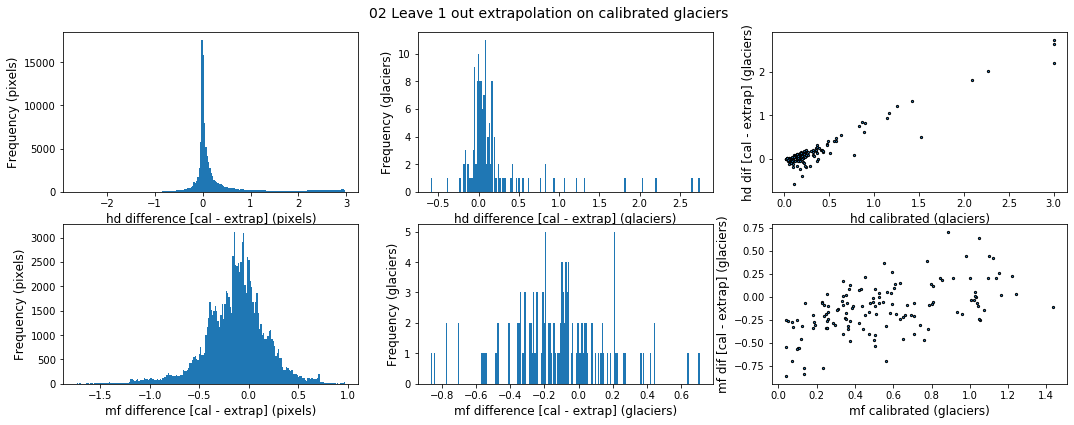

In [8]:
# HISTOGRAMS OF SPREAD
# Setup the pyplot plots
fig = plt.figure(figsize=(18,10)) # Initialize figure with a size
ax1 = fig.add_subplot(331)
ax2 = fig.add_subplot(332)
ax3 = fig.add_subplot(333)
ax4 = fig.add_subplot(334)
ax5 = fig.add_subplot(335)
ax6 = fig.add_subplot(336)

labelsize = 12

fig.text(0.5,0.9, debris_prms.roi + ' Leave 1 out extrapolation on calibrated glaciers', ha='center', size=14)

# ===== DEBRIS THICKNESS PLOTS PLOTS =====
# hd dif pixels
h = ax1.hist(hd_dif_all, bins=200) # see note above regarding vmax adjustments
# ax1.set_title('hd difference [cal - extrap] (pixels)')
ax1.set_ylabel('Frequency (pixels)', size=labelsize)
ax1.set_xlabel('hd difference [cal - extrap] (pixels)', size=labelsize)
print('hd dif (pixels) med/min/max:', np.median(hd_dif_all), np.min(hd_dif_all), np.max(hd_dif_all))

# hd dif glaciers
h = ax2.hist(hd_glac_med_dif_all, bins=200) # see note above regarding vmax adjustments
ax2.set_xlabel('hd difference [cal - extrap] (glaciers)', size=labelsize)
ax2.set_ylabel('Frequency (glaciers)', size=labelsize)

# hd dif vs median thickness
ax3.scatter(hd_glac_med_all, hd_glac_med_dif_all, s=5, marker='o', edgecolor='k')
# ax3.scatter(hd_cal_all, hd_dif_all, s=5, marker='o', edgecolor='k')
ax3.set_xlabel('hd calibrated (glaciers)', size=labelsize)
ax3.set_ylabel('hd dif [cal - extrap] (glaciers)', size=labelsize)

# ===== MELT FACTOR PLOTS =====
# mf dif pixels
h = ax4.hist(mf_dif_all, bins=200) # see note above regarding vmax adjustments
ax4.set_xlabel('mf difference [cal - extrap] (pixels)', size=labelsize)
ax4.set_ylabel('Frequency (pixels)', size=labelsize)
print('mf dif (pixels) med/min/max:', np.median(mf_dif_all), np.min(mf_dif_all), np.max(mf_dif_all))

# mf dif glaciers
h = ax5.hist(mf_glac_med_dif_all, bins=200) # see note above regarding vmax adjustments
ax5.set_xlabel('mf difference [cal - extrap] (glaciers)', size=labelsize)
ax5.set_ylabel('Frequency (glaciers)', size=labelsize)


# mf dif vs median thickness
ax6.scatter(mf_glac_med_all, mf_glac_med_dif_all, s=5, marker='o', edgecolor='k')
ax6.set_xlabel('mf calibrated (glaciers)', size=labelsize)
ax6.set_ylabel('mf dif [cal - extrap] (glaciers)', size=labelsize)

fig.savefig(fig_extrap + '../' + debris_prms.roi + '-hist_hd_mf_differences.png', bbox_inches='tight', 
            pad_inches=0, dpi=150)


Med dist med/min/max: 0.48132271519477193 0.10480352114971977 3.3143078585963353


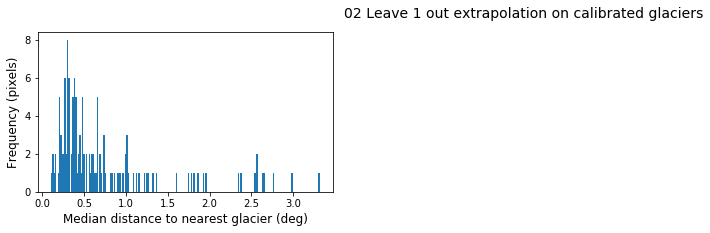

In [9]:
# HISTOGRAMS OF SPREAD
# Setup the pyplot plots
fig = plt.figure(figsize=(18,10)) # Initialize figure with a size
ax1 = fig.add_subplot(331)

labelsize = 12

fig.text(0.5,0.9, debris_prms.roi + ' Leave 1 out extrapolation on calibrated glaciers', ha='center', size=14)

# ===== DEBRIS THICKNESS PLOTS PLOTS =====
# hd dif pixels
h = ax1.hist(hd_latlon_dist_med_all, bins=200) # see note above regarding vmax adjustments
ax1.set_ylabel('Frequency (pixels)', size=labelsize)
ax1.set_xlabel('Median distance to nearest glacier (deg)', size=labelsize)
print('Med dist med/min/max:', np.median(hd_latlon_dist_med_all), np.min(hd_latlon_dist_med_all), 
      np.max(hd_latlon_dist_med_all))

fig.savefig(fig_extrap + '../' + debris_prms.roi + '-hist_nearestdist.png', bbox_inches='tight', 
            pad_inches=0, dpi=150)


In [10]:
# ===== PICKLE DATASETS =====
pickle_fp = debris_prms.output_fp + 'pickle_datasets/'

for roi in ['01', '02', '03', '04', '05', '06', '07', '09', '10', '11', '12', 'HMA', '17', '18']:
# for roi in ['01']:
#     with open(hd_list_all_fullfn, 'rb') as f:
#         hd_list_all = pickle.load(f)

    with open(pickle_fp + roi + '_hd_cal_all.pkl', 'rb') as f:
        hd_cal = pickle.load(f)
    with open(pickle_fp + roi + '_hd_dif_all.pkl', 'rb') as f:
        hd_dif = pickle.load(f)
    with open(pickle_fp + roi + '_hd_glac_med_all.pkl', 'rb') as f:
        hd_glac_med = pickle.load(f)
    with open(pickle_fp + roi + '_hd_glac_med_dif_all.pkl', 'rb') as f:
        hd_glac_med_dif = pickle.load(f)

    with open(pickle_fp + roi + '_mf_cal_all.pkl', 'rb') as f:
        mf_cal = pickle.load(f)
    with open(pickle_fp + roi + '_mf_dif_all.pkl', 'rb') as f:
        mf_dif = pickle.load(f)
    with open(pickle_fp + roi + '_mf_glac_med_all.pkl', 'rb') as f:
        mf_glac_med = pickle.load(f)
    with open(pickle_fp + roi + '_mf_glac_med_dif_all.pkl', 'rb') as f:
        mf_glac_med_dif = pickle.load(f)

    with open(pickle_fp + roi + '_hd_latlon_dist_med_all.pkl', 'rb') as f:
        hd_latlon_dist_med = pickle.load(f)
            
    hd_cal_all = np.concatenate((hd_cal_all, hd_cal), axis=0)
    hd_dif_all = np.concatenate((hd_dif_all, hd_dif), axis=0)
    hd_glac_med_all = np.concatenate((hd_glac_med_all, hd_glac_med), axis=0)
    hd_glac_med_dif_all = np.concatenate((hd_glac_med_dif_all, hd_glac_med_dif), axis=0)

    mf_cal_all = np.concatenate((mf_cal_all, mf_cal), axis=0)
    mf_dif_all = np.concatenate((mf_dif_all, mf_dif), axis=0)
    mf_glac_med_all = np.concatenate((mf_glac_med_all, mf_glac_med), axis=0)
    mf_glac_med_dif_all = np.concatenate((mf_glac_med_all, mf_glac_med_dif), axis=0)

    hd_latlon_dist_med_all = np.concatenate((hd_latlon_dist_med_all, hd_latlon_dist_med), axis=0)
    

hd dif (pixels) med/min/max: 0.0405572522431612 -3.0 2.9999743523330316 0.20804570889828577
mf dif (pixels) med/min/max: -0.07420696690678596 -2.5229742527008057 1.3892563581466675


ValueError: x and y must be the same size

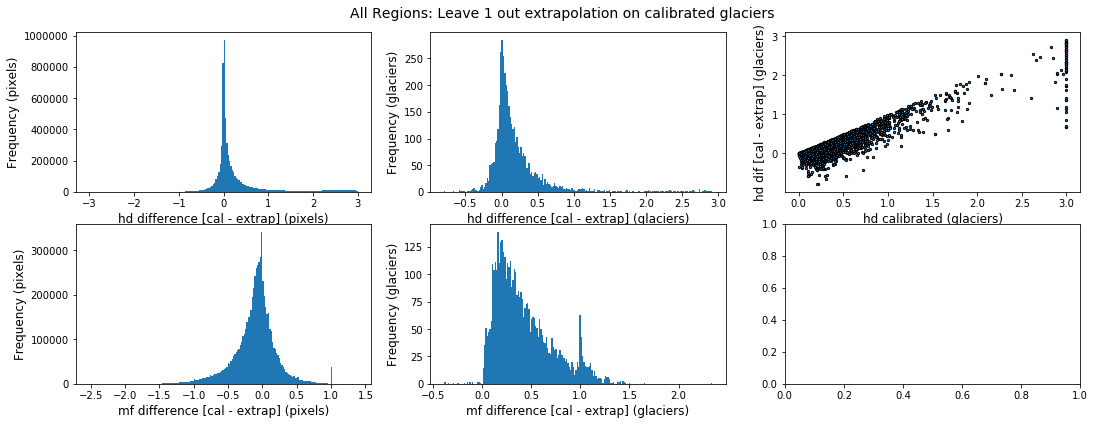

In [15]:
from scipy.stats import median_absolute_deviation

# HISTOGRAMS OF SPREAD
# Setup the pyplot plots
fig = plt.figure(figsize=(18,10)) # Initialize figure with a size
ax1 = fig.add_subplot(331)
ax2 = fig.add_subplot(332)
ax3 = fig.add_subplot(333)
ax4 = fig.add_subplot(334)
ax5 = fig.add_subplot(335)
ax6 = fig.add_subplot(336)

labelsize = 12

fig.text(0.5,0.9, 'All Regions: Leave 1 out extrapolation on calibrated glaciers', ha='center', size=14)

# ===== DEBRIS THICKNESS PLOTS PLOTS =====
# hd dif pixels
h = ax1.hist(hd_dif_all, bins=200) # see note above regarding vmax adjustments
# ax1.set_title('hd difference [cal - extrap] (pixels)')
ax1.set_ylabel('Frequency (pixels)', size=labelsize)
ax1.set_xlabel('hd difference [cal - extrap] (pixels)', size=labelsize)
print('hd dif (pixels) med/min/max:', np.nanmedian(hd_dif_all), np.nanmin(hd_dif_all), np.nanmax(hd_dif_all), 
      1.483 * median_absolute_deviation(hd_dif_all, nan_policy='omit'))

# hd dif glaciers
h = ax2.hist(hd_glac_med_dif_all, bins=200) # see note above regarding vmax adjustments
ax2.set_xlabel('hd difference [cal - extrap] (glaciers)', size=labelsize)
ax2.set_ylabel('Frequency (glaciers)', size=labelsize)

# hd dif vs median thickness
ax3.scatter(hd_glac_med_all, hd_glac_med_dif_all, s=5, marker='o', edgecolor='k')
# ax3.scatter(hd_cal_all, hd_dif_all, s=5, marker='o', edgecolor='k')
ax3.set_xlabel('hd calibrated (glaciers)', size=labelsize)
ax3.set_ylabel('hd dif [cal - extrap] (glaciers)', size=labelsize)

# ===== MELT FACTOR PLOTS =====
# mf dif pixels
h = ax4.hist(mf_dif_all, bins=200) # see note above regarding vmax adjustments
ax4.set_xlabel('mf difference [cal - extrap] (pixels)', size=labelsize)
ax4.set_ylabel('Frequency (pixels)', size=labelsize)
print('mf dif (pixels) med/min/max:', np.median(mf_dif_all), np.min(mf_dif_all), np.max(mf_dif_all))

# mf dif glaciers
h = ax5.hist(mf_glac_med_dif_all, bins=200) # see note above regarding vmax adjustments
ax5.set_xlabel('mf difference [cal - extrap] (glaciers)', size=labelsize)
ax5.set_ylabel('Frequency (glaciers)', size=labelsize)


# mf dif vs median thickness
ax6.scatter(mf_glac_med_all, mf_glac_med_dif_all, s=5, marker='o', edgecolor='k')
ax6.set_xlabel('mf calibrated (glaciers)', size=labelsize)
ax6.set_ylabel('mf dif [cal - extrap] (glaciers)', size=labelsize)

fig.savefig(fig_extrap + '../' + debris_prms.roi + '-hist_hd_mf_differences.png', bbox_inches='tight', 
            pad_inches=0, dpi=150)